<a href="https://colab.research.google.com/github/Hrsh-Venket/OpenCV-intestinal-deformations/blob/main/intestine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install multipagetiff

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage
import scipy
# from scipy.ndimage import median_filters
from scipy import signal
from skimage import exposure
import multipagetiff as mtif
from google.colab.patches import cv2_imshow
from google.colab import drive

In [ ]:
from skimage.filters import threshold_otsu
import numpy as np

def binarise(images):
    image_stack = np.array(images)

    # Get the shape of the image stack
    depth, height, width = image_stack.shape

    # Reshape the image stack into a single 2D image
    combined_image = image_stack.reshape(depth * height, width)

    gray_image = combined_image

    # Compute Otsu's threshold for the combined image
    threshold = threshold_otsu(gray_image)

    # Apply the threshold to the combined image
    thresholded_image = gray_image > threshold

    # Reshape the thresholded image back into a 3D stack
    thresholded_stack = thresholded_image.reshape(depth, height, width)

    return thresholded_stack


In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force&state=p3g1l8c0wn8hvZ0eLtdk9ESpXWpm0GqGgekKCiIo7cM'
/bin/sh: 1: firefox: not found
/bin/sh: 1: google-chrome: not found
/bin/sh: 1: chromium-browser: not found
/usr/bin/open: 882: www-browser: not found
/usr/bin/open: 882: links2: not found
/usr/bin/open: 882: elinks: not found
/usr/bin/open: 882: links: not found
/usr/bin/open: 882: lynx: not found
/usr/bin/open: 882: w3m: not found
xdg-open: no method available for opening

In [ ]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
images = mtif.read_stack("/gdrive/MyDrive/intestine images/2022.12.21_APS018_Infection_PA14-GacA_40X_40%_EM-4_D2_3_7047.tif", units='um')
images= np.array(images)

In [ ]:
meij = []
for s in images:
  meij.append(skimage.filters.meijering(s, sigmas=[0.001], black_ridges=False)>(0.11))
meij = np.array(meij)

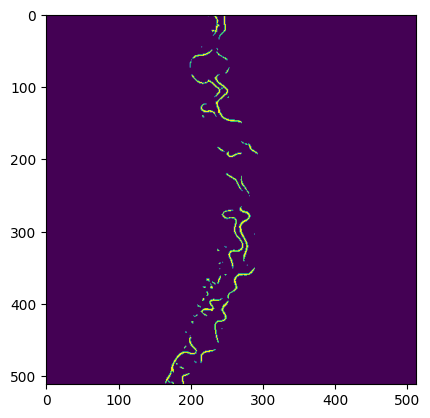

In [ ]:
plt.imshow(meij[7])

In [ ]:
from PIL import Image
img = Image.fromarray(meij[0])
img.save(f'image_{1}.png', bitdepth=16)

In [ ]:
import numpy as np

def create_normalized_kernel(height, width, d, n, sigma=1):
    if height % 2 == 0 or width % 2 == 0:
        raise ValueError("Height and width must be odd")
    center_x, center_y = width // 2, height // 2
    x = np.arange(width)
    y = np.arange(height)
    xv, yv = np.meshgrid(x, y)
    kernel = -d * np.exp(-((xv - center_x) ** 2 + (yv - center_y) ** 2) / (2 * sigma ** 2))
    kernel[center_y, center_x] = n
    kernel /= kernel.sum()
    return kernel

from scipy.signal import convolve2d

def soft_nms(image, decay_parameter=0.45):
  kernel = create_normalized_kernel(1, 5, decay_parameter, 1)
  out = convolve2d(image, kernel, mode='same', boundary='symm')
  out[out < 0] = 0
  return out

def naive_suppression(image: np.ndarray, c: int) -> np.ndarray:
    image = image.astype(np.float32)
    # Subtract c from every pixel of the image
    result = image - c

    # Ensure that pixel values are not less than 0
    result[result < 0] = 0

    return result


In [ ]:
c = 1700
naive_suppressed = []
for img in images:
  naive_suppressed.append(naive_suppression(img, c))
naive_suppressed = np.array(naive_suppressed)

In [ ]:
med_blur_images = signal.medfilt(naive_suppressed, kernel_size=(3,5,5))

In [ ]:
snms = []
for med_img in med_blur_images:
  snms.append(soft_nms(med_img))
snms = np.array(snms)

In [ ]:
import os
import numpy as np
from PIL import Image

# Create a new folder called 'snms' if it doesn't already exist
if not os.path.exists('snms'):
    os.makedirs('snms')

# Assuming snms_med_blur is a 3D numpy array of shape (num_images, height, width)
num_images = snms.shape[0]

for i in range(num_images):
    # Get the i-th image in the stack
    img = snms[i]

    # Normalize the pixel data to the range [0, 65535]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 65535

    # Convert the pixel data to uint16
    img = img.astype(np.uint16)

    # Convert the numpy array to a PIL Image
    img = Image.fromarray(img)

#     # Save the image in png format inside the 'snms' folder
    img.save(f'snms/image_{i}.png', bitdepth=16)

In [ ]:
meij = []
for s in snms:
  meij.append(skimage.filters.meijering(s, sigmas=[1], black_ridges=False)>(0.135))
meij = np.array(meij)

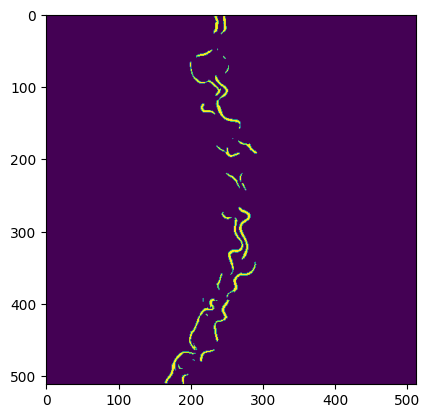

In [ ]:
plt.imshow(meij[7])

In [ ]:
meij[7].dtype

dtype('bool')

In [ ]:
# import cv2
# import numpy as np

# kernel_size = 3
# kernel = cv2.getStructuringElement(cv2.MORPH_OPEN, (kernel_size, kernel_size))

# # Apply morphological closing operation to each binary image
# opened_images = []
# for binary_image in meij:
#     # Convert binary_image to uint8 data type
#     binary_image = binary_image.astype('uint8')
#     closed_img = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=1)
#     opened_images.append(closed_img)

# opened_images = np.array(opened_images)


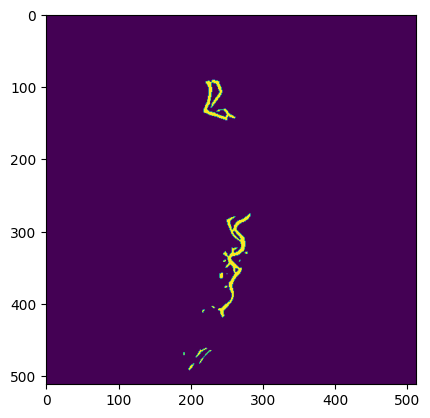

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create a figure and axis
fig, ax = plt.subplots()

# Set the initial image
im = ax.imshow(np.take(meij, 0, axis=0))

# Define the update function
def update(i):
    im.set_data(np.take(meij, i, axis=0))

# Create the animation
ani = FuncAnimation(fig, update, frames=range(meij.shape[0]), interval=1000)

from matplotlib.animation import PillowWriter

# Set up the writer
writer = PillowWriter(fps=2)

# Save the animation
ani.save('intestine.gif', writer=writer)

In [ ]:
from skimage import io, util

def save_binary_stack_as_pngs(stack, output_dir):
    """
    Save each slice of a 3D binary stack as a separate PNG image.

    Parameters
    ----------
    stack : numpy.ndarray
        3D binary stack to be saved as separate PNG images.
    output_dir : str
        Directory where the PNG images will be saved.

    Returns
    -------
    None
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each slice in the stack
    for i, slice in enumerate(stack):
        # Convert the slice to an 8-bit unsigned integer array
        slice = util.img_as_ubyte(slice)
        # Construct the output file path
        file_path = os.path.join(output_dir, f'slice_{i:03d}.png')
        # Save the slice as a PNG image with check_contrast set to False
        io.imsave(file_path, slice, check_contrast=False)


In [ ]:
save_binary_stack_as_pngs(meij, 'images')

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def visualize_bounding_box(image: np.ndarray, box: np.ndarray):
#     # Create a new figure and axis
#     fig, ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(image)

#     # Create a rectangle patch for the bounding box
#     rect = patches.Rectangle((box[0, 0], box[0, 1]), box[0, 2] - box[0, 0], box[0, 3] - box[0, 1], linewidth=1, edgecolor='r', facecolor='none')

#     # Add the rectangle patch to the axis
#     ax.add_patch(rect)

#     # Show the plot
#     plt.show()


# import numpy as np

# def bounding_box(image: np.ndarray, margin=100):
#     rows = np.any(image, axis=1)
#     cols = np.any(image, axis=0)
#     top_left = (np.argmax(rows), np.argmax(cols))
#     bottom_right = (image.shape[0] - 1 - np.argmax(np.flipud(rows)), image.shape[1] - 1 - np.argmax(np.flipud(cols)))
#     top_left = (max(0, top_left[0] - margin), max(0, top_left[1] - margin))
#     bottom_right = (min(image.shape[0] - 1, bottom_right[0] + margin), min(image.shape[1] - 1, bottom_right[1] + margin))
#     return np.array([top_left[1], top_left[0], bottom_right[1], bottom_right[0]])

# def process_image(image, bbox):
#     image = image.astype(np.int32)
#     x1, y1, x2, y2 = bbox
#     mask = np.ones(image.shape, dtype=bool)
#     mask[y1:y2, x1:x2] = False
#     max_val = image[mask].max()
#     result = image - max_val
#     result = np.clip(result, 0, None)
#     return result

# boxes = []
# for bin in binary_images:
#   boxes.append(bounding_box(bin))
# np.array(boxes)

# suppressed = []
# for i in range(images.shape[0]):
#   suppressed.append(process_image(images[i], boxes[i]))
# suppressed = np.array(suppressed)
